In [1]:
target_size = (227,227)
batch_size = 50
IMG_SHAPE = (227, 227)
classes = 5
train_val_split = 0.2
num_classes = 5
nb_epochs =100
#init_epoch = 29
wandb_resume_state = True
exp_name = 'test3'

In [2]:
import shutil 
import os 
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
import seaborn as sns 
from keras.models import save_model
import cv2
from tensorflow.keras.metrics import AUC, Precision, Recall
import wandb
from wandb.keras import WandbCallback

In [3]:
train = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [4]:
train_val_split = 0.2

In [5]:
#train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=train_val_split)
train_data_gen = ImageDataGenerator(rescale = 1./255,
                                    validation_split=train_val_split)
train_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/customdataset/Feature_Extraction', target_size = (227,227), batch_size = 20, class_mode = 'categorical', subset='training') 
validation_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/customdataset/Feature_Extraction', target_size = (227,227), batch_size = 20,  class_mode = 'categorical', subset='validation')

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [6]:
labels = list(train_generator.class_indices.keys())

In [7]:
from keras.models import Sequential
from tensorflow.keras import models, optimizers
from tensorflow.keras.layers import Flatten, Dense, Dropout,MaxPool2D
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
model_alexnet = tf.keras.Sequential([
    Conv2D(input_shape=IMG_SHAPE+(3,), filters=96,kernel_size=11,strides=4,activation='relu'),
    MaxPool2D(pool_size=3,strides=2),
    Conv2D(filters=256,kernel_size=5,strides=1,padding='valid',activation='relu'),
    MaxPool2D(pool_size=3,strides=2),
    Conv2D(filters=384,kernel_size=3,strides=1,padding='same',activation='relu'),
    Conv2D(filters=384,kernel_size=3,strides=1,padding='same',activation='relu'),
    Conv2D(filters=256,kernel_size=3,strides=1,padding='same',activation='relu'),
    MaxPool2D(pool_size=3,strides=2),
    Flatten(),
    #Dense(len(classes), activation='softmax')
    Dense(5, activation='softmax')

], name="model_AlexNet")

In [8]:
model_alexnet.compile(loss='categorical_crossentropy',optimizer = optimizers.RMSprop(learning_rate = 0.001),metrics=['accuracy',Precision(),  Recall(), AUC()])

In [9]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping( patience=3, verbose=1)

In [10]:
history = model_alexnet.fit(train_generator,steps_per_epoch = len(train_generator),
                          validation_data = validation_generator,
                          validation_steps =len( validation_generator),epochs = nb_epochs ,callbacks=[early_stopping])

Epoch 1/100
147/147 [==============================] - 46s 244ms/step - loss: 1.4019 - accuracy: 0.6063 - precision: 0.7860 - recall: 0.3947 - auc: 0.8545 - val_loss: 0.9782 - val_accuracy: 0.6662 - val_precision: 0.9726 - val_recall: 0.3885 - val_auc: 0.9132
Epoch 2/100
147/147 [==============================] - 18s 124ms/step - loss: 0.8278 - accuracy: 0.7131 - precision: 0.8283 - recall: 0.5711 - auc: 0.9141 - val_loss: 0.7882 - val_accuracy: 0.7182 - val_precision: 0.8849 - val_recall: 0.5363 - val_auc: 0.9286
Epoch 3/100
147/147 [==============================] - 18s 123ms/step - loss: 0.7449 - accuracy: 0.7424 - precision: 0.8391 - recall: 0.6353 - auc: 0.9303 - val_loss: 0.7933 - val_accuracy: 0.7031 - val_precision: 0.7784 - val_recall: 0.6197 - val_auc: 0.9219
Epoch 4/100
147/147 [==============================] - 18s 122ms/step - loss: 0.6654 - accuracy: 0.7636 - precision: 0.8391 - recall: 0.6745 - auc: 0.9447 - val_loss: 0.7402 - val_accuracy: 0.7346 - val_precision: 0.8768

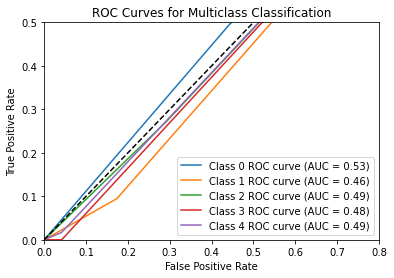

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error,mean_absolute_error
import numpy as np
# Make predictions for the test set
y_pred = model_alexnet.predict(validation_generator)
y_pred = np.argmax(y_pred,axis=1)
y_true = validation_generator.classes

# Binarize the true labels and predictions
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_true))

# Compute the AUC for each class
aucs = []
for i in range(y_true_bin.shape[1]):
    fpr, tpr, thresholds = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    auc = roc_auc_score(y_true_bin[:, i], y_pred_bin[:, i])
    aucs.append(auc)
    plt.plot(fpr, tpr, label='Class {} ROC curve (AUC = {:.2f})'.format(i, auc))

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlim([0.0, 0.8])
plt.ylim([0.0, 0.5])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()
y_true = np.argmax(y_true_bin, axis=1)
y_pred = np.argmax(y_pred_bin, axis=1)


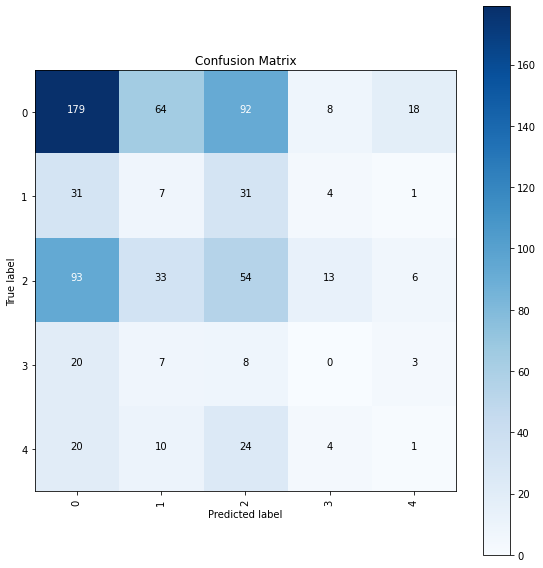

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

# Generate predictions for the test set
#y_pred = model.predict(validation_generator)
#y_pred = np.argmax(y_pred,axis=1)
#y_true = validation_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
class_names = validation_generator.class_indices.keys()

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [13]:
#save model
model_json = model_alexnet.to_json()
with open('model_alexnet.json', 'w') as json_file:
    json_file.write(model_json)

model_saved = save_model(model_alexnet, './weights.hdf5')
#load model
with open('model_alexnet.json', 'r') as json_file:
    json_saved_model = json_file.read()

model_loaded = tf.keras.models.model_from_json(json_saved_model)
model_loaded.load_weights('weights.hdf5')
model_loaded.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#test single image
path = '/kaggle/input/traindata/train/3/0104b032c141.png'
image = cv2.imread(path)
image = cv2.resize(image, (227,227))
image = image/ 255    #normalise
#print(image.shape)
image = image.reshape(-1, 227,227,3)      #reshape in format to send more than one image to predict
#print(image.shape)

result = model_loaded(image)
#print(result)  #probabilities that the image belong to each class
result = np.argmax(result, axis=1)

if(result==0):
    print('Grade 0')
elif(result == 1):
    print('Grade 1')
elif(result == 2):
    print('Grade 2')
elif(result == 3):
    print('Grade 3')
else:
    print('Grade 4')

Grade 0


In [14]:
#train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=train_val_split)
train_data_gen = ImageDataGenerator(rescale = 1./255,
                                    validation_split=train_val_split)
r_train_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/redlesion-customdataset/RedLesion_CustomDataset', target_size = (227,227), batch_size = 20, class_mode = 'categorical', subset='training') 
r_validation_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/redlesion-customdataset/RedLesion_CustomDataset', target_size = (227,227), batch_size = 20,  class_mode = 'categorical', subset='validation')

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [16]:
history = model_alexnet.fit(r_train_generator,steps_per_epoch = len(r_train_generator),
                          validation_data = r_validation_generator,
                          validation_steps =len( r_validation_generator),epochs = nb_epochs ,callbacks=[early_stopping])

Epoch 1/100
147/147 [==============================] - 441s 3s/step - loss: 0.9988 - accuracy: 0.6428 - precision: 0.7999 - recall: 0.4623 - auc: 0.8727 - val_loss: 0.8999 - val_accuracy: 0.6566 - val_precision: 0.9699 - val_recall: 0.3967 - val_auc: 0.9047
Epoch 2/100
147/147 [==============================] - 359s 2s/step - loss: 0.8108 - accuracy: 0.7117 - precision: 0.8250 - recall: 0.5919 - auc: 0.9174 - val_loss: 0.8142 - val_accuracy: 0.6840 - val_precision: 0.8277 - val_recall: 0.5650 - val_auc: 0.9156
Epoch 3/100
147/147 [==============================] - 366s 2s/step - loss: 0.6089 - accuracy: 0.7687 - precision: 0.8393 - recall: 0.6950 - auc: 0.9534 - val_loss: 1.1030 - val_accuracy: 0.6662 - val_precision: 0.6782 - val_recall: 0.6430 - val_auc: 0.8859
Epoch 4/100
147/147 [==============================] - 363s 2s/step - loss: 0.3943 - accuracy: 0.8611 - precision: 0.8926 - recall: 0.8304 - auc: 0.9793 - val_loss: 1.3779 - val_accuracy: 0.6607 - val_precision: 0.6892 - val_r